In [1]:
#Import libraries
import glob,os
import matplotlib.pyplot as plt
import cv2
import shutil  
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import natsort
from numpy import arange, array, arctan,pi, median
#Adjust Image Size (just for plotting)
plt.rcParams["figure.figsize"] = (15,10)

#Import updateXY Function
def updateXY(Xpoint,Ypoint,Direction,i):
    if Direction=='Up':
        xl=int(Xpoint)
        yl=int(Ypoint)-i
    if Direction=='UR':
        xl=int(Xpoint)+i
        yl=int(Ypoint)-i
    if Direction=='Right':
        xl=int(Xpoint)+i
        yl=int(Ypoint)
    if Direction=='DR':
        xl=int(Xpoint)+i
        yl=int(Ypoint)+i
    if Direction=='Down':
        xl=int(Xpoint)
        yl=int(Ypoint)+i
    if Direction=='DL':
        xl=int(Xpoint)-i
        yl=int(Ypoint)+i
    if Direction=='Left':
        xl=int(Xpoint)-i
        yl=int(Ypoint)
    if Direction=='UL':
        xl=int(Xpoint)-i
        yl=int(Ypoint)-i
    return(xl,yl)
#Import IncreaseRes2 Function
def IncreaseRes2(Image,Xpoint,Ypoint,IR_Thr,Direction):
    X_next=[]
    Y_next=[]
    Reasons=[]
    #Move and gather values
    XL_next=[]
    YL_next=[]
    Value_next=[]
    ThereIsNoAnswer=0
    for i in range(10):
        #Moving direction
        xl,yl=updateXY(Xpoint,Ypoint,Direction,i)
        #Making cordinations and values series
        XL_next=XL_next+[xl]
        YL_next=YL_next+[yl]
        try:
            Image[int(yl),int(xl)]
        except:
            ThereIsNoAnswer=1
            Reasons=Reasons+['DimentionError']
            break
        Value_next=Value_next+[Image[int(yl),int(xl)]]
        #Break If there is zero
        if Image[int(yl),int(xl)]==0:
            ThereIsNoAnswer=1
            Reasons=Reasons+['ZeroNum']
            break
        #Break if the value is decreasing   
        if len(Value_next) >1:
            if Value_next[-2]>=Value_next[-1]:
                ThereIsNoAnswer=1
                Reasons=Reasons+['Decreasing']
                break
        #Break if is more than the Threshold
        if Image[int(yl),int(xl)]>=IR_Thr:  
            if len(Value_next)==1:
                #Exception: No answer if direction has Zero
                xl,yl=updateXY(Xpoint,Ypoint,Direction,i+1)
                if Image[int(yl),int(xl)]==0:
                    ThereIsNoAnswer=1
                    Reasons=Reasons+['ZeroNum, wrong direction']
                    break
                if Value_next>Image[int(yl),int(xl)]:
                    ThereIsNoAnswer=1
                    Reasons=Reasons+['Decreasing, wrong direction']
                    break          
            Reasons=Reasons+['OK']
            break
    #Convert Value Matrix to differential value matrix 
    Converted_Value_next=Value_next.copy()
    if ThereIsNoAnswer==0:
        if len(Value_next)==1:
            Converted_Value_next[0]=IR_Thr
        if len(Value_next)>1:
            for i in range(len(Value_next)-1):
                if Converted_Value_next[i+1]>IR_Thr:
                    Converted_Value_next[i+1]=IR_Thr-Value_next[i]
                    break
                Converted_Value_next[i+1]=Value_next[i+1]-Value_next[i]
    if ThereIsNoAnswer==0:
        Cumulative_Value=[] 
        for i in range(len(Converted_Value_next)):        
            Cumulative_Value=Cumulative_Value+[XL_next[i]*Converted_Value_next[i]]
        X_next=X_next+[np.array(Cumulative_Value).sum()/IR_Thr]
        Cumulative_Value=[] 
        for i in range(len(Converted_Value_next)):
            Cumulative_Value=Cumulative_Value+[YL_next[i]*Converted_Value_next[i]]
        Y_next=Y_next+[np.array(Cumulative_Value).sum()/IR_Thr]
    if ThereIsNoAnswer==1:
        X_next=X_next+[0]
        Y_next=Y_next+[0]
        ThereIsNoAnswer=0
    return(X_next, Y_next, Reasons)
#Line equation
def objective(x, a, b):
    return a *x + b       


def xy(test, y_strat, margin_horizontal=250, n_pix=20, x_thr=70, y_thr=70, y_IR_Thr=210 ):
    
    test_show=test.copy()
    test=255-test
    
    left_px_x_list  = []
    right_px_x_list = []
    left_px_y_list  = []
    right_px_y_list = []

    for j in range(n_pix):
        left_px_x = min(np.where([test[y_strat+j,:,0]>x_thr])[1])
        right_px_x = max(np.where([test[y_strat+j,:,0]>x_thr])[1])
        left_px_y, right_px_y= y_strat+j, y_strat+j
        test_show[left_px_y, left_px_x, :] = [0, 0, 255]
        test_show[right_px_y, right_px_x, :] = [0, 0, 255]

        left_px_x_list  = left_px_x_list + [left_px_x]
        right_px_x_list = right_px_x_list + [right_px_x]
        left_px_y_list  = left_px_y_list + [left_px_y]
        right_px_y_list = right_px_y_list + [right_px_y]

    x_position = np.average(left_px_x_list + right_px_x_list)
    x_position_int = int(x_position)
    

    left_px_x_list  = []
    right_px_x_list = []
    left_px_y_list  = []
    right_px_y_list = []
    Dir='Down'
    for i in range(n_pix):
        left_px_y = min(np.where([test[:,x_position_int-margin_horizontal-i,0]>y_thr])[1])
        right_px_y = min(np.where([test[:,x_position_int+margin_horizontal+i,0]>y_thr])[1])
        left_px_x, right_px_x= x_position_int-margin_horizontal-i, x_position_int+margin_horizontal+i
        
        left_px_y_subpx = IncreaseRes2(np.squeeze(test[:,:,0]), left_px_x, left_px_y, y_IR_Thr, Dir)[1]
        right_px_y_subpx = IncreaseRes2(np.squeeze(test[:,:,0]), right_px_x, right_px_y, y_IR_Thr, Dir)[1]
        
        test_show[left_px_y, left_px_x, :] = [0, 0, 255]
        test_show[right_px_y, right_px_x, :] = [0, 0, 255]

        left_px_x_list  = left_px_x_list + [left_px_x]
        right_px_x_list = right_px_x_list + [right_px_x]
        left_px_y_list  = left_px_y_list + [left_px_y_subpx]
        right_px_y_list = right_px_y_list + [right_px_y_subpx]

    y_position = np.average(left_px_y_list + right_px_y_list)
    y_position_max = np.max(left_px_y_list + right_px_y_list)
    
    return( x_position, y_position, y_position_max, test_show)

In [2]:
#Answer This Question
HowManyFramesPerSecond=120
#What is the file address 
ad=r"C:\Users\MPIP.PCBUTT316\Python_lap\ML\Chirag\Forward\Rishi test"
vidcap_ad=ad+"\\"+'5 pass.avi'
#What is the file name
vidcap = cv2.VideoCapture(vidcap_ad)

In [3]:
#Convert Video to Frames
#For chirag: if you did it once, please skip this cell for next time
SelectingRate=1
success,image = vidcap.read()
count=-1
Num=0
NewFolder=ad+"\\"+"Frames"
try:
    os.makedirs(NewFolder)
except:
    shutil.rmtree(NewFolder)
    os.makedirs(NewFolder)
NewFolder=ad+"\\"+"Frames"
print('Frame Selecting+++++++++++++++++++++++++++++++++++++++++++++++++',end='\n')
while True:
    count += 1
    success,image = vidcap.read()
    if count%SelectingRate!=0:
        continue
    try:
        Num+=1
        print(Num,':',count,end=' __ ')
        #image=cv2.flip(image,1)
        cv2.imwrite(NewFolder+"\\"+"%d.tiff" % count, image)
    except:
        break

Frame Selecting+++++++++++++++++++++++++++++++++++++++++++++++++
1 : 0 __ 2 : 1 __ 3 : 2 __ 4 : 3 __ 5 : 4 __ 6 : 5 __ 7 : 6 __ 8 : 7 __ 9 : 8 __ 10 : 9 __ 11 : 10 __ 12 : 11 __ 13 : 12 __ 14 : 13 __ 15 : 14 __ 16 : 15 __ 17 : 16 __ 18 : 17 __ 19 : 18 __ 20 : 19 __ 21 : 20 __ 22 : 21 __ 23 : 22 __ 24 : 23 __ 25 : 24 __ 26 : 25 __ 27 : 26 __ 28 : 27 __ 29 : 28 __ 30 : 29 __ 31 : 30 __ 32 : 31 __ 33 : 32 __ 34 : 33 __ 35 : 34 __ 36 : 35 __ 37 : 36 __ 38 : 37 __ 39 : 38 __ 40 : 39 __ 41 : 40 __ 42 : 41 __ 43 : 42 __ 44 : 43 __ 45 : 44 __ 46 : 45 __ 47 : 46 __ 48 : 47 __ 49 : 48 __ 50 : 49 __ 51 : 50 __ 52 : 51 __ 53 : 52 __ 54 : 53 __ 55 : 54 __ 56 : 55 __ 57 : 56 __ 58 : 57 __ 59 : 58 __ 60 : 59 __ 61 : 60 __ 62 : 61 __ 63 : 62 __ 64 : 63 __ 65 : 64 __ 66 : 65 __ 67 : 66 __ 68 : 67 __ 69 : 68 __ 70 : 69 __ 71 : 70 __ 72 : 71 __ 73 : 72 __ 74 : 73 __ 75 : 74 __ 76 : 75 __ 77 : 76 __ 78 : 77 __ 79 : 78 __ 80 : 79 __ 81 : 80 __ 82 : 81 __ 83 : 82 __ 84 : 83 __ 85 : 84 __ 86 : 85 __ 87 : 86 

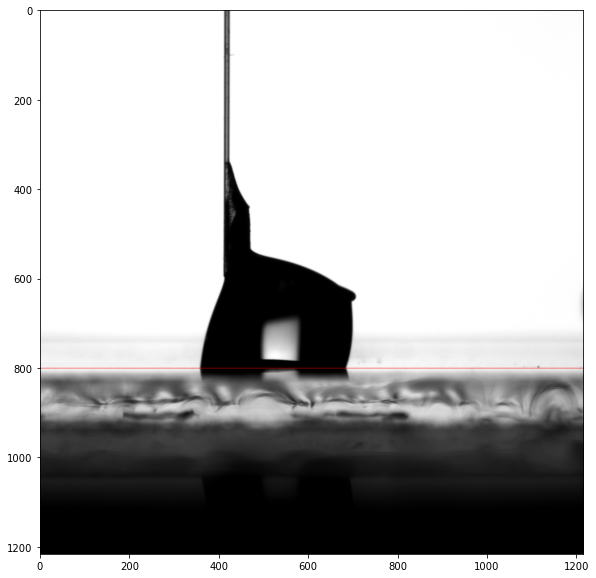

In [4]:
#Calculate for every frame
NewFolder=ad+"\\"+"Frames"
DetectedImages=ad+"\\"+"DetectedImages"
try:
    os.makedirs(DetectedImages)
except:
    shutil.rmtree(DetectedImages)
    os.makedirs(DetectedImages)  
FileName=sorted(os.listdir(NewFolder))
FileNames=[]
for i in range(len(FileName)):
    try:
        if FileName[i].split(".")[1]=="tiff":
            FileNames=FileNames+[FileName[i]]
    except:
        pass
fps=HowManyFramesPerSecond
FileNames=natsort.natsorted(FileNames)



BaseLine=800
test=cv2.imread(NewFolder+"\\"+FileNames[0])
test[BaseLine,:,:]=[255,0,0]

plt.imshow(test)

In [5]:
#Without Y-axis

DetectedImages=ad+"\\"+"DetectedImages"
try:
    os.makedirs(DetectedImages)
except:
    shutil.rmtree(DetectedImages)
    os.makedirs(DetectedImages)  
FileName=sorted(os.listdir(NewFolder))
FileNames=[]
for i in range(len(FileName)):
    try:
        if FileName[i].split(".")[1]=="tiff":
            FileNames=FileNames+[FileName[i]]
    except:
        pass
fps=HowManyFramesPerSecond
FileNames=natsort.natsorted(FileNames)
RDEGREE=[]
ADEGREE=[]
RDEGREEP=[]
ADEGREEP=[]
RDEGREEV=[]
ADEGREEV=[]
file_number=[]
for FileName in FileNames:
    print(FileName,end='_')
    Img=cv2.imread(NewFolder+"\\"+FileName)

    
    #Morphological transformation
    kernel = np.ones((6,6),np.uint8) #3 is maximum allowed number
    Img=cv2.morphologyEx(np.array(Img), cv2.MORPH_OPEN, kernel)
    Img=cv2.morphologyEx(np.array(Img), cv2.MORPH_CLOSE, kernel)
    #Img=cv2.morphologyEx(np.array(Img), cv2.MORPH_OPEN, kernel)
    
    HorizontalStartPoint= 0
    HorizontalEndPoint=1100
    Img_BW=Img[:,:,0]
    Img_WB=255-Img_BW
    # Crop Image
    CroppedIMg=Img_WB[BaseLine-300:BaseLine,HorizontalStartPoint:HorizontalEndPoint]
    CroppedIMg2=Img[BaseLine-300:BaseLine,HorizontalStartPoint:HorizontalEndPoint]
    # Threshold for skipping noises, Y length: how many pixels are needed?
    Thr=80   # 80-120, you can increase it to ignore noises
    YLength=10
    # Find Advancing and Receding Pixels
    X=[]
    Y=[]
    for y in np.arange(CroppedIMg.shape[0]-YLength,CroppedIMg.shape[0]):
        for x in range(CroppedIMg.shape[1]):
             if CroppedIMg[y,x] > Thr:
                #CroppedIMg2[y,x,:]=[255,0,0]
                X=X+[x]
                Y=Y+[y]
                break
    Xl=[]
    Yl=[]
    for y in np.arange(CroppedIMg.shape[0]-YLength,CroppedIMg.shape[0]):
        for x in np.arange(CroppedIMg.shape[1]-1,0,-1):
             if CroppedIMg[y,x] > Thr:
                #CroppedIMg2[y,x,:]=[255,0,0]
                Xl=Xl+[x]
                Yl=Yl+[y]
                break
    #Increase Res 
    IR_Thr=220 #220
    Dir='Right'
    X_updated=[]
    for x in range(len(X)):
        x_updated=IncreaseRes2(CroppedIMg,X[x],Y[x],IR_Thr,Dir)[0]
        X_updated=X_updated+x_updated
    Dir='Left'
    Xl_updated=[]
    for x in range(len(Xl)):
        x_updated=IncreaseRes2(CroppedIMg,Xl[x],Yl[x],IR_Thr,Dir)[0]
        Xl_updated=Xl_updated+x_updated
    popt, _ = curve_fit(objective, X_updated, max(Y)-np.array(Y))
    a, b = popt
    x_line = np.arange(min(X_updated), max(X_updated), .00001)
    y_line = objective(x_line, a, b)
    popt, _ = curve_fit(objective, Xl_updated, max(Yl)-np.array(Yl))
    a, b = popt
    xl_line = np.arange(min(Xl_updated), max(Xl_updated), .00001)
    yl_line = objective(xl_line, a, b)
       
    if len(x_line)!=0:
        dx=x_line[1]-x_line[0]
        dy=y_line[1]-y_line[0]
        gradian=arctan((dy)/(dx))
        if dy*dx<0:
            Rdegree=180+gradian*180/pi
        if dy*dx>0:
            Rdegree=gradian*180/pi
    else:
        Rdegree=90
        
    if len(xl_line)!=0: 
        dx=xl_line[1]-xl_line[0]
        dy=yl_line[1]-yl_line[0]
        gradian=arctan((dy)/(dx))
        if dx==0:
            Adegree=90
        if dy*dx<0:
            Adegree=-gradian*180/pi
        if dy*dx>0:
            Adegree=180-gradian*180/pi
    else:
        Adegree=90
        
        
    CI3=Img[BaseLine-300:BaseLine,HorizontalStartPoint:].copy()
    for x,y in zip(X_updated,Y):
        CI3[round(y),round(x)]=[0,0,255]
    for x,y in zip(Xl_updated,Yl):
        CI3[round(y),round(x)]=[0,0,255]
    
    xc1=np.mean(Xl_updated)
    yc1=np.mean(Yl)
    xc2=np.mean(X_updated)
    yc2=np.mean(Yl)
    CI3[round(yc1),round(xc1)]=[0,255,255]
    CI3[round(yc2),round(xc2)]=[0,255,255]
    cv2.imwrite(DetectedImages+'/image_'+FileName.split('.')[0]+'.tif',CI3)
    file_number.append(int(FileName.split('.')[0]))
    RDEGREE=RDEGREE+[Rdegree]
    ADEGREE=ADEGREE+[Adegree]
    
    RDEGREEP.append(np.mean(X_updated))
    ADEGREEP.append(np.mean(Xl_updated))
    
    
for i in range(len(RDEGREEP)-1):
    RDEGREEV.append(RDEGREEP[i+1]-RDEGREEP[i])
    ADEGREEV.append(ADEGREEP[i+1]-ADEGREEP[i])
RDEGREEV=(np.array(RDEGREEV)*fps)
ADEGREEV=(np.array(ADEGREEV)*fps)

DF=pd.DataFrame([np.arange(len(file_number)), file_number, RDEGREE, ADEGREE, RDEGREE, ADEGREEP, abs(np.array(RDEGREEP)-np.array(ADEGREEP))]
               , index= ["Counter", "File number", "Left angle", "Right angle",  "Left x_position",  "Right x_position", "Contact line"]).T
DF.to_excel(DetectedImages+"\\results.xlsx")

0.tiff_1.tiff_2.tiff_3.tiff_4.tiff_5.tiff_6.tiff_7.tiff_8.tiff_9.tiff_10.tiff_11.tiff_12.tiff_13.tiff_14.tiff_15.tiff_16.tiff_17.tiff_18.tiff_19.tiff_20.tiff_21.tiff_22.tiff_23.tiff_24.tiff_25.tiff_26.tiff_27.tiff_28.tiff_29.tiff_30.tiff_31.tiff_32.tiff_33.tiff_34.tiff_35.tiff_36.tiff_37.tiff_38.tiff_39.tiff_40.tiff_41.tiff_42.tiff_43.tiff_44.tiff_45.tiff_46.tiff_47.tiff_48.tiff_49.tiff_50.tiff_51.tiff_52.tiff_53.tiff_54.tiff_55.tiff_56.tiff_57.tiff_58.tiff_59.tiff_60.tiff_61.tiff_62.tiff_63.tiff_64.tiff_65.tiff_66.tiff_67.tiff_68.tiff_69.tiff_70.tiff_71.tiff_72.tiff_73.tiff_74.tiff_75.tiff_76.tiff_77.tiff_78.tiff_79.tiff_80.tiff_81.tiff_82.tiff_83.tiff_84.tiff_85.tiff_86.tiff_87.tiff_88.tiff_89.tiff_90.tiff_91.tiff_92.tiff_93.tiff_94.tiff_95.tiff_96.tiff_97.tiff_98.tiff_99.tiff_100.tiff_101.tiff_102.tiff_103.tiff_104.tiff_105.tiff_106.tiff_107.tiff_108.tiff_109.tiff_110.tiff_111.tiff_112.tiff_113.tiff_114.tiff_115.tiff_116.tiff_117.tiff_118.tiff_119.tiff_120.tiff_121.tiff_122.tiff_123